# Objective

* Make a baseline model that predict the validation (28 days). 
* This competition has 2 stages, so the main objective is to make a model that can predict the demand for the next 28 days

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as dd
from sklearn import preprocessing, metrics
import gc
import os
from fastai import *
from fastai.tabular import *

In [2]:
?TabularList

In [2]:
torch.cuda.is_available()

True

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# function to read the data and merge it (ignoring some columns, this is a very fst model)


def read_data():
    print('Reading files...')
    path = '/home/shanmugam/fastai/m5'
    calendar = pd.read_csv(f'{path}/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv(f'{path}/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv(f'{path}/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv(f'{path}/sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission


def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    # 
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    # get only a sample for fst training
    data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # delete test2 for now
    data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data
        
calendar, sell_prices, sales_train_validation, submission = read_data()
data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 27500000, merge = True)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 31681090 rows and 18 columns


* We have the data to build our first model, let's build a baseline and predict the validation data (in our case is test1)

In [4]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year

In [5]:
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.week
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek

In [6]:
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price']# 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
#             'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'rolling_skew_t30', 'rolling_kurt_t30']

cat_m = ['snap_WI', 'snap_TX', 'snap_CA', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'year', 'month', 'week', 'day', 'dayofweek', 'sell_price']
cont = [x for x in features if x not in cat_m]
procs = [FillMissing, Categorify, Normalize]
cont

[]

In [7]:
154889209 - 4360070

150529139

In [8]:
data_cp = data.iloc[16192170:].copy()
del data

In [9]:
%who DataFrame

calendar	 data_cp	 sales_train_validation	 sell_prices	 submission	 


In [10]:
del calendar, sales_train_validation, sell_prices

In [11]:
path = '/home/shanmugam/fastai/m5'
bs = 64
tab_db = (TabularList.from_df(data_cp, cat_names=cat_m, cont_names=cont, procs=procs, path=path)
                            .split_by_idxs(train_idx=list(range(0,13781480)),valid_idx=list(range(1859890,14635200)))
                            .label_from_df(cols='demand')
#                              .add_test((TabularList.from_df(data_cp.iloc[14635200:].copy(), cat_names=cat_m, cont_names=cont, path=path)), label=0)
                            .databunch(bs=bs, num_workers=1))

In [12]:
del data_cp

In [26]:
# path = '/home/shanmugam/fastai/m5'
# tab_db = load_data(path, 'mindb', bs=64, num_workers=1)

In [13]:
def rmse_l(val_pred, y_val): return np.sqrt(((y_val - torch.mean(val_pred, dim=1)) ** 2).mean())

In [14]:
learn = tabular_learner(tab_db, layers=[200,100], metrics=[rmse_l]).to_fp16()

In [ ]:
tab_db.save('db1')

In [16]:
learn.fit(1, 1e-1)

epoch,train_loss,valid_loss,rmse_l,time
0,1.315133,nan,nan,1:14:54


epoch,train_loss,valid_loss,rmse_l,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


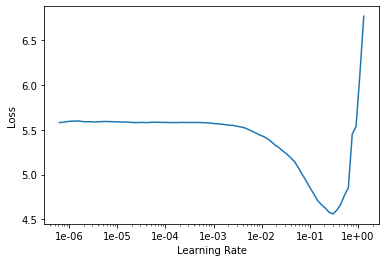

In [15]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.save('minlearn')

In [16]:
preds, y = learn.get_preds(DatasetType.Valid)

KeyboardInterrupt: 

In [17]:
sub = data_cp.iloc[14635200:].copy()
del data_cp
y = torch.argmax(preds, dim=1)

In [18]:
sub['demand'] = y
predictions = sub[['id', 'date', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.to_csv('submission.csv', index = False)